In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# Validation & Metrics
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Synthesis
from sdv.single_table import CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from imblearn.over_sampling import ADASYN, SMOTE

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
# --- CONFIGURATION ---
processed_data_dir = '../data/processed'
imputation_methods = ['mice', 'knn', 'softimpute', 'gain'] # Add 'pmm' if available
target_col = 'mayo'

# SDV Paramters
SDV_EPOCHS = 50 # Lowered from 300 for feasibility. Increase for final production run.
SDV_SAMPLES = 252 # How many synthetic samples to generate (matches orig dataset size approx)

# Validation Parameters
N_SPLITS = 2
N_REPEATS = 5
RANDOM_STATE = 42

In [ ]:
def augment_data(X_train, y_train, method):
    """
    Trains a synthesizer on X_train/y_train and returns an Augmented dataset.
    Uses StandardScaler internally for SDV methods.
    """
    # Standardize first (Best practice for GANs/VAEs)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    
    if method in ['ctgan', 'tvae']:
        # Prepare data for SDV
        df_train_scaled = pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1)
        metadata = SingleTableMetadata()
        metadata.detect_from_dataframe(data=df_train_scaled)
        
        if method == 'ctgan':
            model = CTGANSynthesizer(metadata, epochs=SDV_EPOCHS, verbose=False)
        else:
            model = TVAESynthesizer(metadata, epochs=SDV_EPOCHS, verbose=False)
            
        model.fit(df_train_scaled)
        
        # Generate
        synthetic_scaled = model.sample(num_rows=len(X_train))
        
        # Inverse Transform Features
        X_syn_scaled = synthetic_scaled.drop(columns=[target_col])
        y_syn = synthetic_scaled[target_col]
        
        X_syn = pd.DataFrame(scaler.inverse_transform(X_syn_scaled), columns=X_train.columns)
        
        # Return Augmented (Original + Synthetic)
        X_aug = pd.concat([X_train, X_syn], axis=0).reset_index(drop=True)
        y_aug = pd.concat([y_train, y_syn], axis=0).reset_index(drop=True)
        
        return X_aug, y_aug
        
    elif method in ['adasyn', 'smote']:
        
        if method == 'adasyn':
            # FIX: Lower n_neighbors to 2 or 3 to handle small sample sizes in CV folds
            try:
                sampler = ADASYN(sampling_strategy='not majority', n_neighbors=3, random_state=RANDOM_STATE)
                X_res_scaled, y_res = sampler.fit_resample(X_train_scaled, y_train)
            except ValueError:
                # Fallback to 1 neighbor if even 3 is too many
                sampler = ADASYN(sampling_strategy='not majority', n_neighbors=1, random_state=RANDOM_STATE)
                X_res_scaled, y_res = sampler.fit_resample(X_train_scaled, y_train)

        else:
            sampler = SMOTE(sampling_strategy='not majority', random_state=RANDOM_STATE)
            X_res_scaled, y_res = sampler.fit_resample(X_train_scaled, y_train)
            
        try:
            X_res = pd.DataFrame(scaler.inverse_transform(X_res_scaled), columns=X_train.columns)
            return X_res, y_res
        except ValueError as e:
            # Fallback if it completely fails
            print(f"    {method.upper()} failed ({e}), returning original.")
            return X_train, y_train
            
    else: # None / Baseline
        return X_train, y_train

In [4]:
def get_models():
    return {
        'RF': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE),
        'CatBoost': CatBoostClassifier(iterations=500, random_seed=RANDOM_STATE, verbose=0),
        'Stacking': StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)),
                ('cb', CatBoostClassifier(iterations=500, random_seed=RANDOM_STATE, verbose=0))
            ], 
            final_estimator=LogisticRegression()
        )
    }

## Main Execution Loop

In [5]:
results = []
rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)
synthesis_methods = ['ctgan', 'tvae', 'adasyn', 'smote']

total_start = time.time()

for imp_method in imputation_methods:
    file_path = os.path.join(processed_data_dir, f'uc_diagnostic_tests_{imp_method}.csv')
    if not os.path.exists(file_path): 
        print(f"Skipping {imp_method}: File not found.")
        continue
        
    df = pd.read_csv(file_path)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    print(f"\n{'='*50}\nIMPUTATION: {imp_method.upper()}\n{'='*50}")
    
    for syn_method in synthesis_methods:
        print(f"  > Synthesis: {syn_method}")
        
        fold_idx = 0
        for train_index, test_index in rskf.split(X, y):
            start_time = time.time()
            
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # --- LEAK-FREE AUGMENTATION ---
            # Synthesizer ONLY sees X_train/y_train
            X_train_aug, y_train_aug = augment_data(X_train, y_train, syn_method)
            
            # --- EVALUATION ---
            models = get_models()
            for model_name, model in models.items():
                model.fit(X_train_aug, y_train_aug)
                y_pred = model.predict(X_test)
                
                # Metrics
                bal_acc = balanced_accuracy_score(y_test, y_pred)
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                results.append({
                    'imputation': imp_method,
                    'synthesis': syn_method,
                    'model': model_name,
                    'fold_id': fold_idx,
                    'balanced_accuracy': bal_acc,
                    'accuracy': acc,
                    'f1_weighted': f1
                })
            
            elapsed = time.time() - start_time
            print(f"    Fold {fold_idx}/10 done in {elapsed:.1f}s", end='\r')
            fold_idx += 1
        print("") # Newline after folds

results_df = pd.DataFrame(results)
print(f"\nTotal Experiment Time: {(time.time() - total_start)/60:.1f} minutes")


IMPUTATION: MICE
  > Synthesis: ctgan
    Fold 9/10 done in 23.8s
  > Synthesis: tvae
    Fold 9/10 done in 20.9s
  > Synthesis: adasyn
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    Fold 9/10 done in 11.6s
  > Synthesis: smote
    Fold 9/10 done in 10.9s

IMPUTATION: KNN
  > Synthesis: ctgan
    Fold 9/10 done in 25.1s
  > Synthesis: tvae
    Fold 9/10 done in 20.7s
  > Synthesis: adasyn
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samp

In [6]:
# Save Results for safety
results_df.to_csv('rigorous_evaluation_results.csv', index=False)
results_df.head()

,imputation,synthesis,model,fold_id,balanced_accuracy,accuracy,f1_weighted
0,mice,ctgan,RF,0,0.346903,0.404762,0.364971
1,mice,ctgan,CatBoost,0,0.391448,0.428571,0.414847
2,mice,ctgan,Stacking,0,0.342747,0.373016,0.362656
3,mice,ctgan,RF,1,0.334416,0.365079,0.350029
4,mice,ctgan,CatBoost,1,0.333097,0.357143,0.349803


## Analysis and Visualization

In [7]:
# 1. Summary Table
summary_df = results_df.groupby(['imputation', 'synthesis', 'model']).agg({
    'balanced_accuracy': ['mean', 'std'],
    'accuracy': 'mean',
    'f1_weighted': 'mean'
}).reset_index()

summary_df.columns = ['imputation', 'synthesis', 'model', 'mean_balanced_accuracy', 'std_balanced_accuracy', 'mean_accuracy', 'mean_f1_weighted']
best_config = summary_df.sort_values(by='mean_balanced_accuracy', ascending=False).iloc[0]

print("Top 5 Rigorous Configurations:")
display(summary_df.sort_values(by='mean_balanced_accuracy', ascending=False).head(5))

Top 5 Rigorous Configurations:


,imputation,synthesis,model,mean_balanced_accuracy,std_balanced_accuracy,mean_accuracy,mean_f1_weighted
0,gain,adasyn,CatBoost,0.428471,0.048548,0.446825,0.439280
6,gain,smote,CatBoost,0.425519,0.037497,0.437302,0.431749
8,gain,smote,Stacking,0.424091,0.046527,0.450000,0.439368
7,gain,smote,RF,0.417535,0.042239,0.430159,0.426134
1,gain,adasyn,RF,0.402019,0.047042,0.426984,0.414389


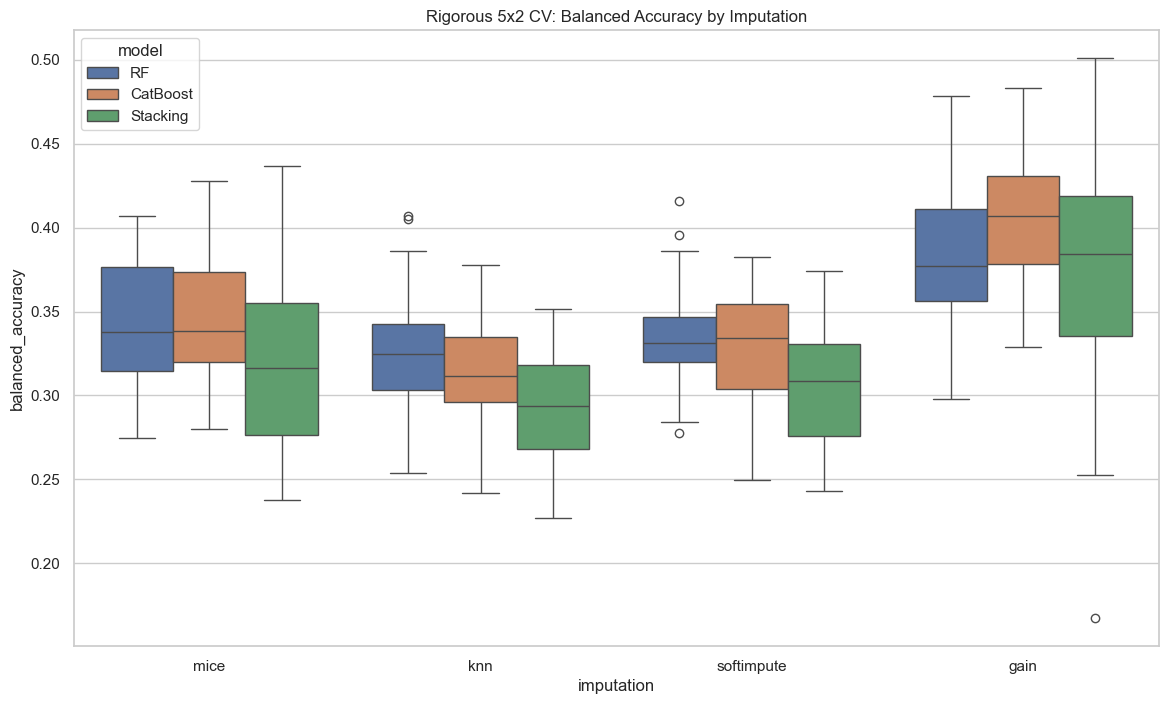

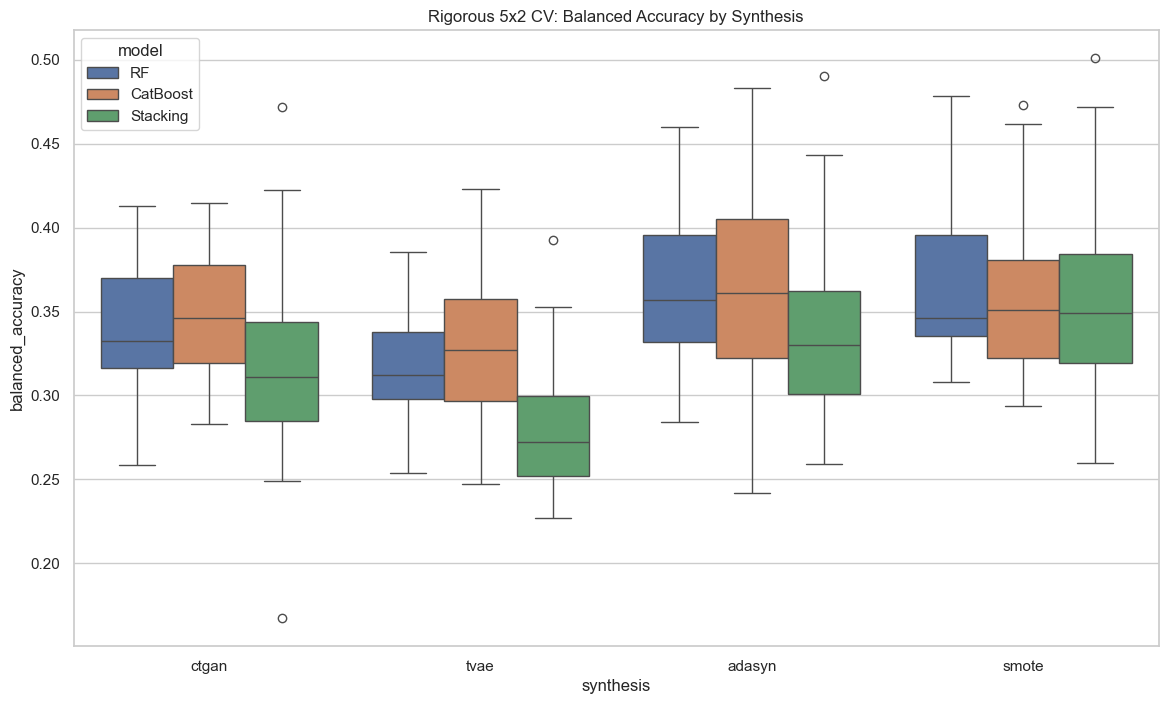

In [8]:
# 2. Boxplot Distributions
plt.figure(figsize=(14, 8))
sns.boxplot(data=results_df, x='imputation', y='balanced_accuracy', hue='model')
plt.title('Rigorous 5x2 CV: Balanced Accuracy by Imputation')
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(data=results_df, x='synthesis', y='balanced_accuracy', hue='model')
plt.title('Rigorous 5x2 CV: Balanced Accuracy by Synthesis')
plt.show()

Generating Visuals for WINNER: gain + adasyn (CatBoost)
Re-running CV for Confusion Matrix aggregation...
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.
    ADASYN failed (No samples will be generated with the provided ratio settings.), returning original.


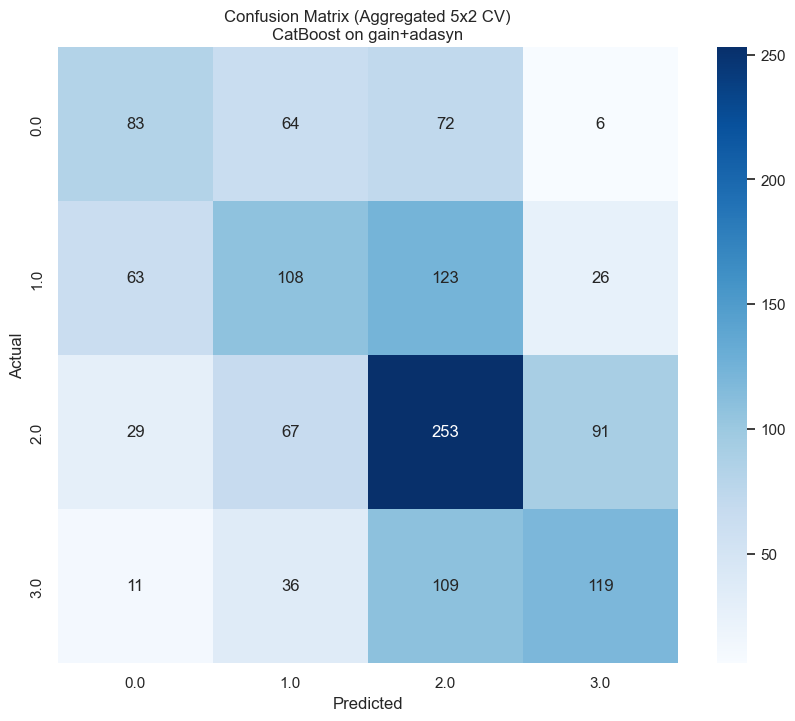

In [9]:
# 3. Confusion Matrix for Best Config (Re-run one last time on full Stratified Split to visualize)
# Note: To be perfectly rigorous, we should aggregate confusion matrices from the CV loop.
# Let's rerun the best config specifically to collect predictions.

best_imp = best_config['imputation']
best_syn = best_config['synthesis']
best_mod = best_config['model']

print(f"Generating Visuals for WINNER: {best_imp} + {best_syn} ({best_mod})")

file_path = os.path.join(processed_data_dir, f'uc_diagnostic_tests_{best_imp}.csv')
df = pd.read_csv(file_path)
X = df.drop(columns=[target_col])
y = df[target_col]

models_map = get_models()
model = models_map[best_mod]

labels = np.unique(y)
cm_total = np.zeros((len(labels), len(labels)), dtype=int)

print("Re-running CV for Confusion Matrix aggregation...")
for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Augment
    X_train_aug, y_train_aug = augment_data(X_train, y_train, best_syn)
    
    # Fit/Predict
    model.fit(X_train_aug, y_train_aug)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_total += cm

plt.figure(figsize=(10, 8))
sns.heatmap(cm_total, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Aggregated 5x2 CV)\n{best_mod} on {best_imp}+{best_syn}')
plt.show()